In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!pip install -r /content/gdrive/MyDrive/Project/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 161 kB/s 
     |████████████████████████████████| 10.7 MB 89.9 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 68 kB 9.2 MB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 250 kB 83.4 MB/s 
     |████████████████████████████████| 5.8 MB 86.3 MB/s 
     |████████████████████████████████| 451 kB 96.6 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
     |████████████████████████████████| 8.2 MB 88.2 MB/s 
     |████████████████████████████████| 9.2 MB 81.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.9 MB 81.3 MB/s 
     |████████████████████████████████| 1.3 MB 66.1 MB/s 
     |████████████████████████████████| 7.6 MB 73.5 MB/s 
     |████████████████████████████████|

In [3]:
import argparse
import json
import pandas as pd
import numpy as np
from simpletransformers.classification import ClassificationModel
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import contractions
import nltk
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data analysis

In [4]:
def load_input(df):
    if type(df) != pd.DataFrame:
        df = pd.read_json(df, lines=True)
    
    ret = []
    for _, i in df.iterrows():
        ret += [{'text': ' '.join(i['postText']) + ' - ' + i['targetTitle'] + ' ' + ' '.join(i['targetParagraphs']),
                 'uuid': i['uuid'],
                  'target' : i['tags'][0]}]
    
    return pd.DataFrame(ret)

def expand_words(text):
    expanded_words = []   
    for word in text:
        expanded_words.append(contractions.fix(word))  
    
    return expanded_words

In [5]:
train = load_input('/content/gdrive/MyDrive/Project/train.jsonl')
test = load_input('/content/gdrive/MyDrive/Project/validation.jsonl')

noise = stopwords.words('english') + list(punctuation) + ['«', '»', '``', '\'\'', '–', '—', '’']
train['text_tokenized'] = train['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: expand_words(x))
test['text_tokenized'] = test['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: expand_words(x))

X_train, y_train = train['text_tokenized'].apply(lambda x : ' '.join(x)).values, train['target'].values
X_test, y_test = test['text_tokenized'].apply(lambda x : ' '.join(x)).values, test['target'].values

In [ ]:
## классы несбалансированы

train['target'].value_counts()

phrase     1367
passage    1274
multi       559
Name: target, dtype: int64

In [ ]:
## Выборочно проверили на опечатки в ворде, опечаток не обнаружено :) 

In [ ]:
## найдем топ 300 слов по встречаемости во всех предложениях
top300 = train['text_tokenized'].explode().value_counts().head(300)
top20 = top300.head(20)
top300

's        11606
one        5309
said       4654
n't        4326
people     4229
          ...  
free        434
behind      433
major       431
donald      431
whole       430
Name: text_tokenized, Length: 300, dtype: int64

In [ ]:
## найдем топ 5 слов по встречаемости во всех предложениях по классам
top300 = train.groupby('target')['text_tokenized'].apply(lambda x : x.explode().value_counts().head(5))
pd.DataFrame(top300)

text_tokenized
target                        
multi   's                2542
        one               1403
        n't               1205
        people            1177
        like              1071
passage 's                4477
        one               1986
        said              1871
        inc.              1854
        like              1656
phrase  's                4587
        one               1920
        said              1915
        n't               1533
        like              1412

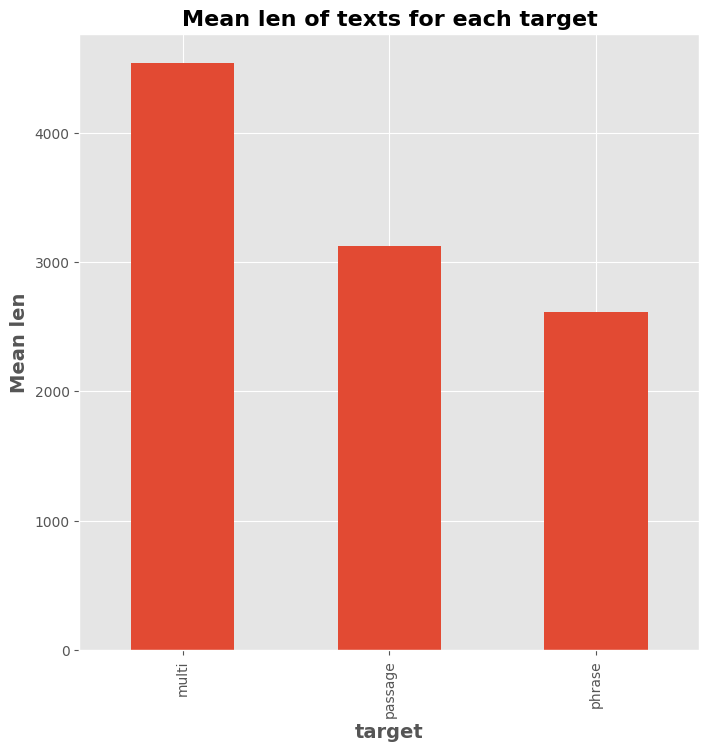

In [ ]:
import matplotlib.pyplot as plt
train['len_text'] = train['text'].str.len()

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

plt.title('Mean len of texts for each target', size=16, weight='bold')

plt.xlabel('Target', size=14, weight='bold')
plt.ylabel('Mean len', size=14, weight='bold')

train['len_text'] = train['text'].str.len()
train.groupby('target')['len_text'].mean().sort_values(ascending=False).plot.bar()

plt.show()

## Средняя длина текста ментше в фразах и больше в multi, что вполне закономерно

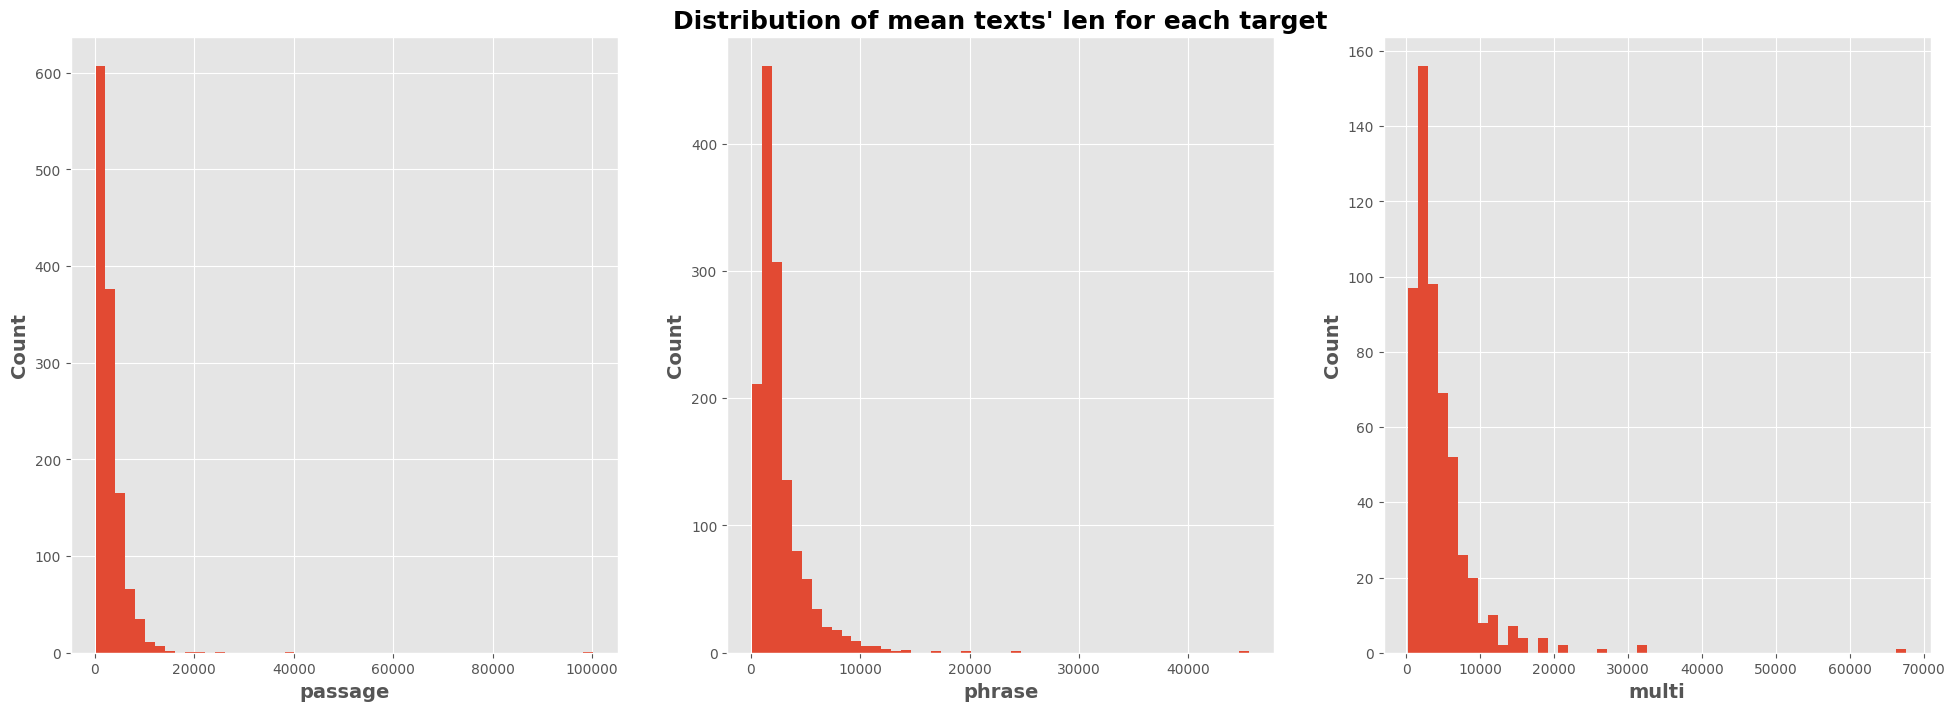

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[1].set_title('Distribution of mean texts\' len for each target', size=18, weight='bold')

for i, target in enumerate(train['target'].unique()):
    train[train['target'] == target]['len_text'].plot.hist(ax=axs[i], bins=50)
    
    axs[i].set_xlabel(target, size=14, weight='bold')
    axs[i].set_ylabel('Count', size=14, weight='bold')

## Baselines

В соревновании был предоставлен код для получения двух бейзлайнов:

Baseline1 - предсказание одного класса "passage"

Baseline2 - предсказания, полученные с помощью fine-tuned трансформера

Посчитаем бейзлайны:

In [ ]:
from sklearn.metrics import f1_score

y_pred = np.full(len(y_test), 'passage')
print('Macro F1 for baseline1:', f1_score(y_test, y_pred, average='macro'))

Macro F1 for baseline1: 0.19132501485442663


In [ ]:
def use_cuda():
    return torch.cuda.is_available() and torch.cuda.device_count() > 0

def predict(df):
    df = load_input(df)
    labels = ['phrase', 'passage', 'multi']
    model = ClassificationModel('deberta', '/kaggle/input/webisclickbait/spoiler-type-classification', use_cuda=use_cuda())

    uuids = list(df['uuid'])
    texts = list(df['text'])
    predictions = model.predict(texts)[1]
    
    for i in range(len(df)):
        yield {'uuid': uuids[i], 'spoilerType': labels[np.argmax(predictions[i])]}

def run_baseline(input_file, output_file):
    predictions = []
    for prediction in predict(input_file):
        predictions.append(prediction)
    return predictions

In [ ]:
pred = run_baseline('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl', 'res.jsonl')
pred = list(map(lambda x : x['spoilerType'], pred))

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import f1_score

y_true = load_input('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl')['target']
print('Macro F1 for baseline2:' ,f1_score(y_true, pred, average='macro'))

Macro F1 for baseline2: 0.7385822029349418


## Наша модель

In [ ]:
## 5-folds CV

In [ ]:
for fold in range(5):
    with open(f'data.train_fold{fold + 1}.txt', 'w', encoding='utf-8') as outfile:
        for i in np.delete(np.arange(X_train.shape[0]), np.arange(fold * X_train.shape[0] // 5, (fold + 1) * X_train.shape[0] // 5)):
            outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

In [ ]:
import fasttext
from tqdm.notebook import tqdm

scores = []
epochs = [5, 10, 20, 30, 50]

for epoch in tqdm(epochs):
    scores.append([])
    for fold in range(5):
        classifier = fasttext.train_supervised(f'data.train_fold{fold + 1}.txt', epoch=epoch)
        y_pred = classifier.predict(X_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5].tolist())
        score = f1_score(np.array(list(map(lambda x : "__label__" + x,
                                y_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5]))),
                                np.array(y_pred[0]).squeeze(), average='macro')
        scores[-1].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5176195 lr:  0.000000 avg.loss:  1.100602 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 5274725 lr:  0.000000 avg.loss:  1.099013 ETA:   0h 0m 0s
Read 0M words
Number of words:  61190
Number of labels: 3
Progress: 100.0% words/sec/thread: 4028152 lr:  0.000000 avg.loss:  1.098850 ETA:   0h 0m 0s
Read 0M words
Number of words:  60802
Number of labels: 3
Progress: 100.0% words/sec/thread: 5133986 lr:  0.000000 avg.loss:  1.099810 ETA:   0h 0m 0s
Read 0M words
Number of words:  61468
Number of labels: 3
Progress: 100.0% words/sec/thread: 5159489 lr:  0.000000 avg.loss:  1.099296 ETA:   0h 0m 0s
Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5147142 lr:  0.000000 avg.loss:  1.062831 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 4

In [ ]:
scores = np.array(scores)
scores

array([[0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.33924742, 0.34832921, 0.30679876, 0.3435452 , 0.35240257],
       [0.49068761, 0.46627909, 0.45879365, 0.43958607, 0.48307471],
       [0.48118693, 0.45495829, 0.46358096, 0.45237287, 0.5027806 ]])

In [ ]:
scores = scores.mean(axis=1)

Text(0, 0.5, 'f1')

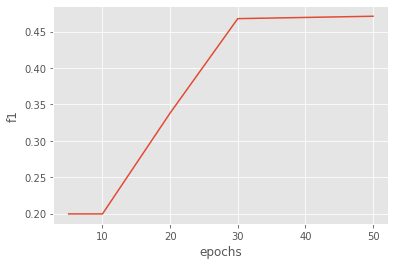

In [ ]:
plt.plot(epochs, scores)
plt.xlabel('epochs')
plt.ylabel('f1')

In [ ]:
best_epoch = 50

with open('data.train.txt', 'w', encoding='utf-8') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
        
classifier = fasttext.train_supervised('data.train.txt', epoch=best_epoch)

Read 0M words
Number of words:  68227
Number of labels: 3
Progress: 100.0% words/sec/thread: 4865597 lr:  0.000000 avg.loss:  0.445100 ETA:   0h 0m 0s


In [ ]:
y_pred = classifier.predict(X_test.tolist())
print('Macro F1:', f1_score(np.array(list(map(lambda x : "__label__" + x, y_test))),
                            np.array(y_pred[0]).squeeze(), average='macro'))

Macro F1: 0.46217413313852723


Наша базовая модель побила baseline1, однако далека от второго бейзлайна.

#Покоряем вершину под названием второй baseline

Поменяем названия колонок для обучения трансформеров, а также преобразуем целевую колонку:

In [6]:
train = train.rename(columns={"target":"label"})
test = test.rename(columns={"target":"label"})

In [7]:
df_train = train[["text", "label"]]

In [8]:
df_train.head(5)

,text,label
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",passage
1,NASA sets date for full recovery of ozone hole...,phrase
2,This is what makes employees happy -- and it's...,phrase
3,Passion is overrated — 7 work habits you need ...,multi
4,The perfect way to cook rice so that it's perf...,phrase


In [9]:
import numpy as np

In [10]:
mapper = {"passage": 0, "phrase":1, "multi":2}
# используем маппер, чтобы колонку label подготовить для multiclass classification problem
train["label"] = train["label"].replace(mapper)
train_data = train[["text", "label"]]
train_data

,text,label
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",0
1,NASA sets date for full recovery of ozone hole...,1
2,This is what makes employees happy -- and it's...,1
3,Passion is overrated — 7 work habits you need ...,2
4,The perfect way to cook rice so that it's perf...,1
...,...,...
3195,Has Facebook's video explosion completely shak...,0
3196,Cop Is Eating At A Chili's When Teen Hands Him...,0
3197,5 popular myths about visible signs of aging t...,2
3198,You need to see this Twitter account that pred...,1


In [11]:
test["label"] = test["label"].replace(mapper)
test_data = test[["text", "label"]]
test_data

,text,label
0,Five Nights at Freddy’s Sequel Delayed for Wei...,0
1,Why Arizona Sheriff Joe Arpaio’s fate could ha...,2
2,Here’s how much you should be tipping your hai...,1
3,"""Harry Potter"" alums reunite for new movie - A...",2
4,A man swallowed a microSD card and you won't b...,0
...,...,...
795,This is what happens when you leave a hotel cl...,0
796,This Texas GOP elector announces that he won't...,1
797,This beauty queen cured her acne with one diet...,2
798,WikiLeaks' Julian Assange Reported Dead - Wiki...,0


### Transformers training section:

обработаем данные с помощью berttokenizer

In [41]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DebertaForSequenceClassification, DebertaTokenizer
from transformers import AlbertForSequenceClassification, AlbertTokenizer
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# обрабатываем текст с помощью токенизатора, тут тоже выносим в одну функцию, чтобы можно было использовать токенайзеры разных моделей:
def encoding_data(tokenizer, max_length=512, batch_size=4):
    encoded_data_train = tokenizer.batch_encode_plus(
        train_data["text"].values,
        add_special_tokens=True, 
        truncation="longest_first",
        return_attention_mask=True, 
        padding=True, 
        max_length=512, 
        return_tensors='pt',
    )

    encoded_data_val = tokenizer.batch_encode_plus(
        test_data["text"].values, 
        add_special_tokens=True,
        truncation="longest_first", 
        return_attention_mask=True, 
        padding=True,
        max_length=512, 
        return_tensors='pt',
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_data["label"].values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(test_data["label"].values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    dataloader_train = DataLoader(dataset_train, 
                                  sampler=RandomSampler(dataset_train), 
                                  batch_size=batch_size)

    dataloader_validation = DataLoader(dataset_val, 
                                      sampler=SequentialSampler(dataset_val), 
                                      batch_size=batch_size)
    return dataloader_train, dataloader_validation

In [13]:
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [65]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

# функции для подсчета метрик: 
# acuracy, f1 - так как организаторы ее используют у себя в файлике для подсчета baseline метрики, и balanced_accuracy - ее используют при сабмите на соревнование
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def balanced_accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return balanced_accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in mapper.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [15]:
def evaluate(model, df_val, device):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in df_val:
        # тут также как и в training функции, будем данные прокидывать батчами в связи с ограниченностью нашего окружения.
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
          
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(df_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

# функция для обучения, ее решили вынести в одну функцию, чтобы можно было разные модели пробовать:
def training(model_name, model, epochs, df_train, df_val, path_to_folder):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  print(f'Training session for {model_name} model:')
  optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(df_train)*epochs)
  for epoch in tqdm(range(1, epochs+1)):
      model.train()
      loss_train_total = 0
      progress_bar = tqdm(df_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:
          model.zero_grad()
          # будем все обрабатывать батчами ибо у нас ограниченные ресурсы нашего окружения
          batch = tuple(b.to(device) for b in batch)
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       
          outputs = model(**inputs)
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
      path_to_save = path_to_folder + "/" + model_name + "_epoch_" + str(epoch) + ".model"
      torch.save(model.state_dict(), path_to_save)
      tqdm.write(f'\nEpoch {epoch}')    
      loss_train_avg = loss_train_total/len(df_train)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      val_loss, predictions, true_vals = evaluate(model, df_val, device)
      val_acc = accuracy_score_func(predictions, true_vals)
      val_balanced_acc = balanced_accuracy_score_func(predictions, true_vals)
      val_f1 = f1_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'Accuracy Score: {val_acc}')
      tqdm.write(f'Balanced Accuracy Score: {val_balanced_acc}')
      tqdm.write(f'F1 Score (Macro): {val_f1}')

Рассмотрим много разных видов трансформеров, основанных на BERT моделе, а также авторегрессионную модель XLNET

### BERT training session:

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train, val = encoding_data(tokenizer, 512, 8)

In [29]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
bert_storage = "/content/gdrive/MyDrive/Project/storage_for_BERT"
training("BERT", bert_model, 5, train, val, bert_storage)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Training session for BERT model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0053112776577473
Validation loss: 0.9743953788280487
Accuracy Score: 0.51375
Balanced Accuracy Score: 0.45834515905898127
F1 Score (Macro): 0.4657391405562766


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8657778690755368
Validation loss: 0.8253409966826439
Accuracy Score: 0.6525
Balanced Accuracy Score: 0.6085899823732399
F1 Score (Macro): 0.6261238889000911


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6798073357716202
Validation loss: 0.8260481537878513
Accuracy Score: 0.66375
Balanced Accuracy Score: 0.630553742169576
F1 Score (Macro): 0.6495111535814925


Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5189956092834472
Validation loss: 0.8835395184159279
Accuracy Score: 0.6625
Balanced Accuracy Score: 0.6152646834022564
F1 Score (Macro): 0.6357058637021183


Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.4070987550728023
Validation loss: 0.8977273650467396
Accuracy Score: 0.67
Balanced Accuracy Score: 0.6295319000705114
F1 Score (Macro): 0.6482920916540699


In [31]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

bert_model.to(device)

bert_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_BERT/BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(bert_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Class: passage
Accuracy: 233/322

Class: phrase
Accuracy: 238/335

Class: multi
Accuracy: 65/143



### RoBERTa training session:

In [32]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train, val = encoding_data(tokenizer, 512, 8)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [33]:
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
roberta_storage = "/content/gdrive/MyDrive/Project/storage_for_RoBERTa"
training("RoBERTa", roberta_model, 5, train, val, roberta_storage)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Training session for RoBERTa model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0009239083528518
Validation loss: 0.889594258069992
Accuracy Score: 0.555
Balanced Accuracy Score: 0.5222700077339922
F1 Score (Macro): 0.5400866049109837


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8111034320294856
Validation loss: 0.7389097203314304
Accuracy Score: 0.68875
Balanced Accuracy Score: 0.6640746015827131
F1 Score (Macro): 0.6805178616627053


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6383064908534288
Validation loss: 0.6844336014986038
Accuracy Score: 0.73125
Balanced Accuracy Score: 0.7130132251482024
F1 Score (Macro): 0.7274913220773094


Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5025479396246374
Validation loss: 0.7297434360533953
Accuracy Score: 0.7225
Balanced Accuracy Score: 0.7068617949214965
F1 Score (Macro): 0.7206154611748176


Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.4026647930685431
Validation loss: 0.769295623600483
Accuracy Score: 0.72625
Balanced Accuracy Score: 0.7102887594775978
F1 Score (Macro): 0.7249823974057938


In [35]:
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

roberta_model.to(device)

roberta_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_RoBERTa/RoBERTa_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(roberta_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Class: passage
Accuracy: 264/322

Class: phrase
Accuracy: 226/335

Class: multi
Accuracy: 91/143



### DeBERTa training session:

In [53]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
train, val = encoding_data(tokenizer, 512, 4)

In [37]:
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
deberta_storage = "/content/gdrive/MyDrive/Project/storage_for_DeBERTa"
training("DeBERTa", deberta_model, 5, train, val, deberta_storage)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

Training session for DeBERTa model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.901367158703506
Validation loss: 0.7222601614892483
Accuracy Score: 0.71375
Balanced Accuracy Score: 0.6735787898020216
F1 Score (Macro): 0.6981170476838537


Epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6959486353117973
Validation loss: 0.7107981157302856
Accuracy Score: 0.7175
Balanced Accuracy Score: 0.6906271751177657
F1 Score (Macro): 0.7070199160479178


Epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5709038489812519
Validation loss: 0.8212458357121796
Accuracy Score: 0.76125
Balanced Accuracy Score: 0.7354373292725013
F1 Score (Macro): 0.7521244015823233


Epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4457311793687404
Validation loss: 1.1630821202800143
Accuracy Score: 0.74
Balanced Accuracy Score: 0.7279942640098382
F1 Score (Macro): 0.7314961380556236


Epoch 5:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3512469612697896
Validation loss: 1.2593289360788185
Accuracy Score: 0.74875
Balanced Accuracy Score: 0.7411170918633605
F1 Score (Macro): 0.7444436659148596


In [55]:
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

deberta_model.to(device)

deberta_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_DeBERTa/DeBERTa_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(deberta_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

Class: passage
Accuracy: 253/322

Class: phrase
Accuracy: 245/335

Class: multi
Accuracy: 101/143



### ALBERT training session:

In [56]:
tokenizer = AlbertTokenizer.from_pretrained("textattack/albert-base-v2-imdb")
train, val = encoding_data(tokenizer, 512, 8)

In [39]:
albert_model = AlbertForSequenceClassification.from_pretrained("textattack/albert-base-v2-imdb",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)
albert_storage = "/content/gdrive/MyDrive/Project/storage_for_ALBERT"
training("ALBERT", albert_model, 5, train, val, albert_storage)

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at textattack/albert-base-v2-imdb and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training session for ALBERT model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9325758807361126
Validation loss: 0.7961407992243766
Accuracy Score: 0.64625
Balanced Accuracy Score: 0.6144541160764393
F1 Score (Macro): 0.6331428409648462


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7201566229388118
Validation loss: 0.742730643749237
Accuracy Score: 0.6775
Balanced Accuracy Score: 0.6308812321141977
F1 Score (Macro): 0.6537940238788569


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.49826346583664416
Validation loss: 0.8002311588823795
Accuracy Score: 0.68125
Balanced Accuracy Score: 0.6524196115370677
F1 Score (Macro): 0.6676126430480925


Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2982128457399085
Validation loss: 0.8928102475404739
Accuracy Score: 0.69375
Balanced Accuracy Score: 0.6628519220342711
F1 Score (Macro): 0.6789595015948109


Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.17323393737897277
Validation loss: 0.9697390080615879
Accuracy Score: 0.67875
Balanced Accuracy Score: 0.6480789813690527
F1 Score (Macro): 0.6646706538656311


In [57]:
albert_model = AlbertForSequenceClassification.from_pretrained("textattack/albert-base-v2-imdb",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)

albert_model.to(device)

albert_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_ALBERT/ALBERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(albert_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at textattack/albert-base-v2-imdb and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: passage
Accuracy: 222/322

Class: phrase
Accuracy: 247/335

Class: multi
Accuracy: 74/143



### XLNET training section:

In [58]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
train, val = encoding_data(tokenizer, 512, 8)

In [43]:
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)
xlnet_storage = "/content/gdrive/MyDrive/Project/storage_for_XLNET"
training("XLNET", xlnet_model, 5, train, val, xlnet_storage)

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Training session for XLNET model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.024374841451645
Validation loss: 1.0612417185306549
Accuracy Score: 0.45625
Balanced Accuracy Score: 0.3836532059763727
F1 Score (Macro): 0.3050568150328588


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9261543945223093
Validation loss: 0.9308994615077972
Accuracy Score: 0.54125
Balanced Accuracy Score: 0.49938022176828145
F1 Score (Macro): 0.49969268353689555


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8297348654270172
Validation loss: 0.8717935499548912
Accuracy Score: 0.61625
Balanced Accuracy Score: 0.5960678084623575
F1 Score (Macro): 0.6049046595306939


Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7011746856570243
Validation loss: 0.883614002764225
Accuracy Score: 0.65375
Balanced Accuracy Score: 0.6203336140390001
F1 Score (Macro): 0.6374154811515863


Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5933672348409891
Validation loss: 0.8753544819355011
Accuracy Score: 0.675
Balanced Accuracy Score: 0.6395893096736706
F1 Score (Macro): 0.6578503069441264


In [59]:
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)

xlnet_model.to(device)

xlnet_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_XLNET/XLNET_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(xlnet_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Class: passage
Accuracy: 218/322

Class: phrase
Accuracy: 252/335

Class: multi
Accuracy: 70/143



### DistilBERT training section:

In [62]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")
train, val = encoding_data(tokenizer, 512, 8)

In [46]:
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      ignore_mismatched_sizes=True)
distilbert_storage = "/content/gdrive/MyDrive/Project/storage_for_DistilBert"
training("DistilBERT", distilbert_model, 5, train, val, distilbert_storage)

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

Training session for DistilBERT model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0122031019628048
Validation loss: 0.9795107293128967
Accuracy Score: 0.49375
Balanced Accuracy Score: 0.5123467274667793
F1 Score (Macro): 0.4661084685904428


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8968029316514731
Validation loss: 0.8655526888370514
Accuracy Score: 0.59
Balanced Accuracy Score: 0.5454594075619384
F1 Score (Macro): 0.5685783223706081


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7891295550763607
Validation loss: 0.8394150179624558
Accuracy Score: 0.62
Balanced Accuracy Score: 0.5860443471734841
F1 Score (Macro): 0.6016926668197896


Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6742814549058675
Validation loss: 0.8389324712753295
Accuracy Score: 0.62375
Balanced Accuracy Score: 0.5884268446241191
F1 Score (Macro): 0.6054177005212962


Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5824804983660579
Validation loss: 0.85509545981884
Accuracy Score: 0.62875
Balanced Accuracy Score: 0.5896948174040971
F1 Score (Macro): 0.6093214446762051


Из всех обученных моделей, лучше всего себя показала модель DeBERTa, ее и используем для сабмита + она побила baseline2